In [131]:
import hidden.hw2_util as util
DIR = util._dir()

In [132]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from platform import python_version
assert int(python_version().split(".")[1]) >= 5, "Your Python version is " + python_version()

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import nltk
nltk.download('reuters', download_dir = DIR) #to specify download location, optionally add the argument: download_dir='/specify/desired/path/'
from nltk.corpus import reuters

import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to
[nltk_data]     /home/athena--/projects/school/nlp/hw/2/hidden...
[nltk_data]   Package reuters is already up-to-date!


In [133]:
def read_corpus(category="gold"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [134]:
# NOTE: manually add path to nltk
if DIR not in nltk.data.path:
    nltk.data.path.append(DIR)

reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'western', 'mining', 'to', 'open', 'new', 'gold', 'mine', 'in', 'australia', 'western',
  'mining', 'corp', 'holdings', 'ltd', '&', 'lt', ';', 'wmng', '.', 's', '>', '(', 'wmc', ')',
  'said', 'it', 'will', 'establish', 'a', 'new', 'joint', 'venture', 'gold', 'mine', 'in', 'the',
  'northern', 'territory', 'at', 'a', 'cost', 'of', 'about', '21', 'mln', 'dlrs', '.', 'the',
  'mine', ',', 'to', 'be', 'known', 'as', 'the', 'goodall', 'project', ',', 'will', 'be', 'owned',
  '60', 'pct', 'by', 'wmc', 'and', '40', 'pct', 'by', 'a', 'local', 'w', '.', 'r', '.', 'grace',
  'and', 'co', '&', 'lt', ';', 'gra', '>', 'unit', '.', 'it', 'is', 'located', '30', 'kms', 'east',
  'of', 'the', 'adelaide', 'river', 'at', 'mt', '.', 'bundey', ',', 'wmc', 'said', 'in', 'a',
  'statement', 'it', 'said', 'the', 'open', '-', 'pit', 'mine', ',', 'with', 'a', 'conventional',
  'leach', 'treatment', 'plant', ',', 'is', 'expected', 'to', 'produce', 'about', '50', ',', '000',
  'ounces', 'of', 'gold'

In [135]:
def distinct_words(corpus: list[list[str]]) -> tuple[list[str], int]:
    """ 
    Determine a list of distinct words for the corpus.

    Params:
        corpus (list of list of strings): corpus of documents

    Return:
        corpus_words (list of strings): sorted list of distinct words across the corpus
        n_corpus_words (integer): number of distinct words across the corpus
    """
    import numpy as np
    
    w = np.array([word for sentence in corpus for word in sentence])

    w = np.unique(ar = w)
    return list(w), len(w)

In [136]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [137]:
from numpy.typing import NDArray

def compute_co_occurrence_matrix(corpus: list[list[str]], window_size: int = 4) -> tuple[NDArray[np.float32], dict[int, int]]:
    """ 
    Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
    Note:
    -----
        Each word in a document should be at the center of a window. Words near edges will have a smaller
        number of co-occurring words.
        
        For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
        "All" will co-occur with "<START>", "that", "glitters", "is", and "not".

    Params:
    -------
        corpus (list of list of strings): corpus of documents
        window_size (int): size of context window

    Return:
    -------
        M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
            Co-occurence matrix of word counts. 
            The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.

        word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    
    corpus_index, n = distinct_words(corpus)
    M = np.zeros(shape = (n, n), dtype = np.float32)
    word2ind = dict(zip(corpus_index, range(n)))

    ''' 
    NOTE: 
        rows : words in the corpus
        columns : words that appear in the same context window
        values : how often those words appear together
    '''

    for context in corpus:
        for center in range(len(context)):
            for frame in range(-window_size, window_size + 1):

                # boundary management
                if center + frame >= len(context): break
                if center + frame < 0 or frame == 0 : continue
                
                M[word2ind[context[center]], word2ind[context[center + frame]]] += 1
    return M, word2ind

In [138]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [139]:
from numpy.typing import NDArray

def reduce_to_k_dim(M: NDArray[np.float32], k: int = 2):
    """ 
        Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
        -------
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
        -------
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
            In terms of the SVD from math class, this actually returns U * S
    """    
    
    from sklearn.decomposition import TruncatedSVD

    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    svd = TruncatedSVD(n_components = k, n_iter = n_iters, random_state = 42)
    M_reduced = svd.fit_transform(M)

    print("Done.")
    return M_reduced

In [140]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [141]:
import matplotlib.pyplot as plt

def plot_embeddings(M_reduced: np.ndarray[np.float32], word2ind: dict[str, int], words: list[str]) -> None:
    """ 
    Plot in a scatterplot the embeddings of the words specified in the list "words".
    
    NOTE: do not plot all the words listed in M_reduced / word2ind.
    Include a label next to each point.
        
    Params:
        M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensional word embeddings
        word2ind (dict): dictionary that maps word to indices for matrix M
        words (list of strings): words whose embeddings we want to visualize
    """

    plt.figure(figsize = (8, 4)) # (width, height)

    x = []
    y = []

    for w in words:
        if w in word2ind:
            i = word2ind[w]
            x.append(M_reduced[i, 0])
            y.append(-M_reduced[i, 1])
            plt.text(M_reduced[i, 0] + 0.00009, -M_reduced[i, 1] + 0.00009, w, fontsize = 7)

    plt.scatter(x, y, marker = 'x', color = 'red')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Word Embeddings")
    plt.grid(True)
    plt.show()

--------------------------------------------------------------------------------
Outputted Plot:


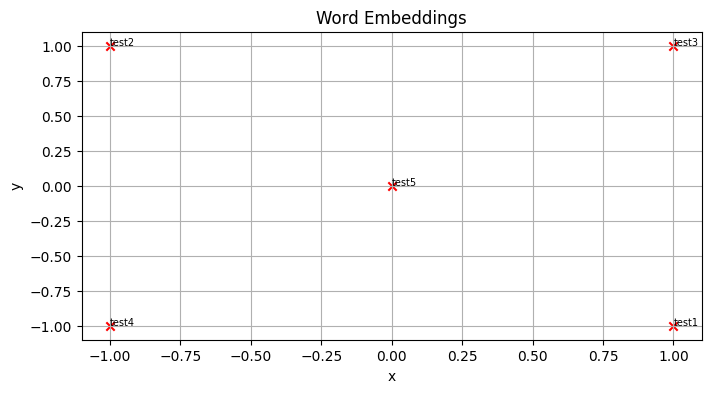

--------------------------------------------------------------------------------


In [142]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

Running Truncated SVD over 2830 words...
Done.


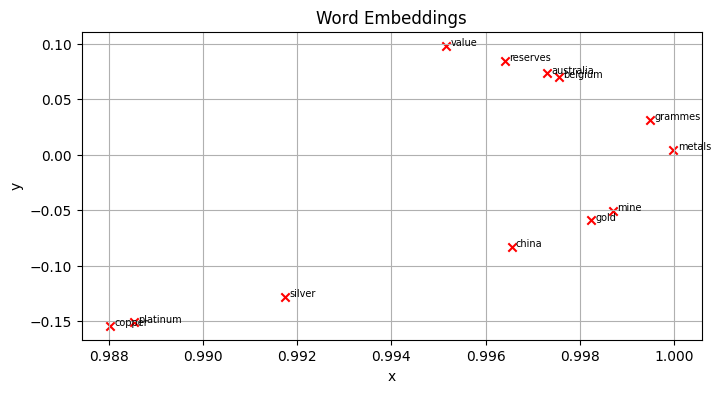

In [143]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis = 1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['value', 'gold', 'platinum', 'reserves', 'silver', 'metals', 'copper', 'belgium', 'australia', 'china', 'grammes', "mine"]

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

**Verify that your figure matches "question_1.5.png" in the assignment zip. If not, use that figure to answer the next two questions.**
![Embedding space plot](imgs/question_1.5.png)

a. Find at least two groups of words that cluster together in 2-dimensional embedding space. Give an explanation for each cluster you observe.

<font color="red"><strong>Answer:</strong><font>

<font color="Green">
    <strong>
    1. (Gold, Mine): gold is a precious metal that's typically gathered/farmed from a mine.
    <br>
    2. (Grammes, Metals): grammes is a unit of measurement for a metal's mass.
<font>

b. What doesn't cluster together that you might think should have? Describe at least two examples.

<font color="red"><strong>Answer:</strong><font>

<font color="Green">
    <strong>
        1. (China, (Australia, Belgium)): all three are countries, and Australia and Belgium are very close.
        <br>
        2. (Silver, (Gold, (Platinum, Copper))): silver is the only metal that's not directly paired with at least one other metal. 
<font>

## Part 2: Prediction-Based Word Vectors (60 pts)

More recently, prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe.

Run the following cells to load the GloVe vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [144]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin

In [145]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


### Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead.
Run the following cells to:

1. Put 10000 Glove vectors into a matrix M
2. Run `reduce_to_k_dim` (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [146]:
def get_matrix_of_vectors(wv_from_bin, required_words):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [147]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin, words)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10012 words...
Done.


### Question 2.1: GloVe Plot Analysis [written] (12 pts)

Run the cell below to plot the 2D GloVe embeddings for:

 `['value', 'gold', 'platinum', 'reserves', 'silver', 'metals', 'copper', 'belgium', 'australia', 'china', 'grammes', "mine"]`.

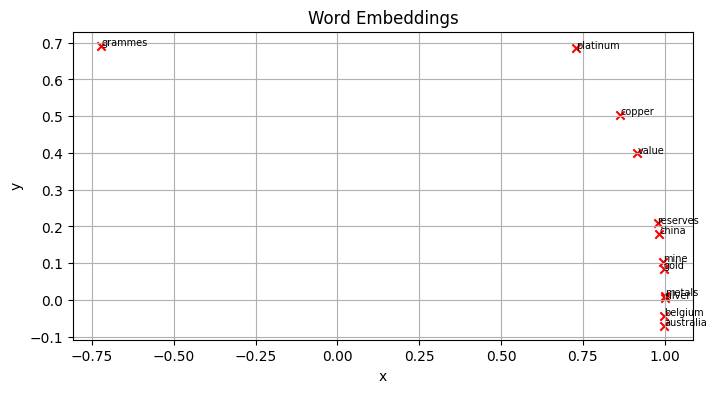

In [148]:
words = ['value', 'gold', 'platinum', 'reserves', 'silver', 'metals', 'copper', 'belgium', 'australia', 'china', 'grammes', "mine"]

plot_embeddings(M_reduced_normalized, word2ind, words)

a. What is one way the plot is different from the one generated earlier from the co-occurrence matrix? What is one way it's similar?

<font color="red"><strong>Answer:</strong><font>

<font color="Green">
    <strong>
        Different
        <br>-----------
        <br>'grammes' is completely isolated now.
        <br>'metal' is shifted to neighboring 'silver'
        <br>'china' and 'reserves' are also very near now.
        <br><br>
        Similar
        <br>-----------
        <br>the relationship between 'belgium' and 'australia' seems preserved
        <br>'mine' and 'gold' are still pairing
    </strong>
</font>

b. What is a possible cause for the difference?

<font color="red"><strong>Answer:</strong></font>

<font color="Green">
    <strong>
        GloVe uses different techniques -- like predictive based stats.
        <br>GloVe is also a pretrained network, so it's scope is global vs my coefficient matrix is local (reuters)
        <br><br>Sources:
        <br>----------
    </strong>
</font>

__[github](https://github.com/stanfordnlp/GloVe?tab=readme-ov-file)__
__[stanford](https://nlp.stanford.edu/projects/glove/)__

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="./imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### Question 2.2: Words with Multiple Meanings [code + written] (6 pts)
Polysemes and homonyms are words that have more than one meaning. Find a word with *at least two different meanings* such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one. 

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [149]:
similar_words = wv_from_bin.most_similar("light", topn=10)
pprint.pprint(similar_words)


[('bright', 0.6242774724960327),
 ('dark', 0.6141002178192139),
 ('lights', 0.6013951897621155),
 ('lighter', 0.558175265789032),
 ('heavy', 0.5408364534378052),
 ('sunlight', 0.5362919569015503),
 ('blue', 0.5349379777908325),
 ('colored', 0.5282376408576965),
 ('sky', 0.5239452719688416),
 ('color', 0.513929009437561)]


<font color="red"><strong>Answer:</strong></font>

<font color="green">
<strong>
    Light   
    <br>-------
    <br>bright  
    <br>dark  
    <br>lights  
    <br>lighter  
    <br>heavy  
    <br>sunlight  
    <br>blue  
    <br>colored  
    <br>sky  
    <br>colo
<br><br>Homonyms are probably tricky to capture because the context is completely different, so the word pairings just don't get associated as frequently.
<br>I remember as a kid, I had to read the dictionary -- Long story. I got in trouble at school. It was a form of punishment -- and I discovered that 'light' had like 50 different definitions. 
<br>So I figured it'd be a good choice.
</strong>
</font>



### Question 2.3: Synonyms & Antonyms [code + written] (8 pts)

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words $(w_1,w_2,w_3)$ where $w_1$ and $w_2$ are synonyms and $w_1$ and $w_3$ are antonyms, but Cosine Distance $(w_1,w_3) <$ Cosine Distance $(w_1,w_2)$. 

As an example, $w_1$="happy" is closer to $w_3$="sad" than to $w_2$="cheerful". Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [150]:
w1 = "fast"
w2 = "quick"
w3 = "slow"

w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)

print("Synonyms '{}', '{}' have cosine distance: {}".format(w1.upper(), w2.upper(), w1_w2_dist))
print("Antonyms '{}', '{}' have cosine distance: {}".format(w1.upper(), w3.upper(), w1_w3_dist))

Synonyms 'FAST', 'QUICK' have cosine distance: 0.3328641653060913
Antonyms 'FAST', 'SLOW' have cosine distance: 0.2522680163383484


<font color="red"><strong>Answer:</strong><font>

<font color="green">
<strong> 
    <br>fast
    <br>quick  
    <br>slow  
    <br><br>Synonyms 'FAST', 'QUICK' have cosine distance: 0.3328641653060913
    <br>Antonyms 'FAST', 'SLOW' have cosine distance: 0.2522680163383484
    <br><br>I'd wager maybe 'slow' and 'fast' are used together on contexts where comparisons are being made.
    <br>Since 'fast' was already used in a statement, 'quick' might be unnecessary/redundant in actual language.
    <br>So it's not used as often near 'fast' because it's not necessary to convey the adjective with fast already filling that role. 
</strong>
</font>

### Question 2.4: Analogies with Word Vectors [written] (6 pts)
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : grandfather :: woman : x" (read: man is to grandfather as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x using the `most_similar` function from the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar)__. The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://www.aclweb.org/anthology/N18-2039.pdf)). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [151]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793),
 ('granddaughter', 0.7200808525085449),
 ('daughter', 0.7168302536010742),
 ('mother', 0.7151536345481873),
 ('niece', 0.7005682587623596),
 ('father', 0.6659887433052063),
 ('aunt', 0.6623408794403076),
 ('grandson', 0.6618767976760864),
 ('grandparents', 0.644661009311676),
 ('wife', 0.6445354223251343)]


Let $m$, $g$, $w$, and $x$ denote the word vectors for `man`, `grandfather`, `woman`, and the answer, respectively. Using **only** vectors $m$, $g$, $w$, and the vector arithmetic operators $+$ and $-$ in your answer, to what expression are we maximizing $x$'s cosine similarity?

Hint: Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector. Where would `man` and `woman` lie in the coordinate plane relative to `grandfather` and the answer?

<font color="red"><strong>Answer:</strong></font>

<font color="sky blue"><strong>
In the context of the code:</strong>

`wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man'])`

```python
    positive = [...] # represents what you're ADDING TO the vector
    negative = [...] # represents what you're SUBTRACTING FROM the vector
```
<strong>
So with: </strong></font>

`man : grandfather :: woman : x`

<font color= "sky blue">

- adding the `'woman'` vector shifts to clusters where NN's are related to `'woman'`
- adding the `'grandfather'` vector shifts to clusters of ~ `'elder man'`
  - now we have `'woman'` + `'elder man'`
- subtracting the `'man'` vector removes the male related NN's (`'elder man'` - `'man'` = `'elder'`)
- we're left with the `'woman'` vector + `'elder'` vector.
- now on a 2d grid, the vector space we're in is approximate to `'elder woman'`

The equation can be represented as $x = w + g − m$

<strong>
Source:
</strong>

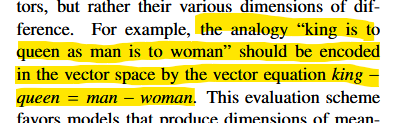

__[GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf)__

### Question 2.5: Finding Analogies [code + written]  (6 pts)
a. For the previous example, it's clear that "grandmother" completes the analogy. But give an intuitive explanation as to why the `most_similar` function gives us words like "granddaughter", "daughter", or "mother?

<font color="red"><strong>Answer:</strong><font>

<font color = "sky blue"><strong>
The cosine similarites are based on co occurences in context, so these other words also have a high statistical probability from occuring near `grandmother` in context.


b. Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [152]:

x, y, a, b = "cat", "kitten", "dog", "puppy"
assert wv_from_bin.most_similar(positive=[a, y], negative=[x])[0][0] == b

<font color="red"><strong>Answer:

<font color = "sky blue">
cat : kitten :: dog : puppy

### Question 2.6: Incorrect Analogy [code + written] (6 pts)
a. Below, we expect to see the intended analogy "hand : glove :: foot : **sock**", but we see an unexpected result instead. Give a potential reason as to why this particular analogy turned out the way it did?

In [153]:
pprint.pprint(wv_from_bin.most_similar(positive=['foot', 'glove'], negative=['hand']))

[('45,000-square', 0.4922032654285431),
 ('15,000-square', 0.4649604558944702),
 ('10,000-square', 0.4544755816459656),
 ('6,000-square', 0.44975775480270386),
 ('3,500-square', 0.444133460521698),
 ('700-square', 0.44257497787475586),
 ('50,000-square', 0.4356396794319153),
 ('3,000-square', 0.43486514687538147),
 ('30,000-square', 0.4330596923828125),
 ('footed', 0.43236875534057617)]


<font color="red"><strong>Answer:
<font color = "sky blue">

So, in place in the equation:

$sock = foot + glove - hand$

Adding the vectors `foot` and `glove`, I'd envision that the vector would move into a space associating apparel with body parts. Maybe even sport apparel?

Then after subtracting the `hand` vector, you shift away from sport **apparel**, and into `glove` and `square feet` vectorspace.

Which to me feels like a basball diamond, maybe?  And the feet represents distances the ball was hit/caught with a [baseball] glove, and/or the sizes of baseball diamonds.

Obviously the low hanging fruit would be because `square feet` is very common in co occurences.  

*...but I'm trying to make adding the* `glove` *vector make sense...*

b. Find another example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the **incorrect** value of b according to the word vectors (in the previous example, this would be **'45,000-square'**).

In [154]:
x, y, a, b = "archer", "bow", "knight", "sword"
pprint.pprint(wv_from_bin.most_similar(positive=[a, y], negative=[x]))

[('worn', 0.46209779381752014),
 ('jhaw', 0.4462401568889618),
 ('jacket', 0.4413919746875763),
 ('wore', 0.4384702146053314),
 ('wear', 0.4280456006526947),
 ('shirt', 0.4221014678478241),
 ('wearing', 0.41978177428245544),
 ('jackets', 0.4127270579338074),
 ('visor', 0.41146576404571533),
 ('blue', 0.4054458439350128)]


<font color="red"><strong>Answer:

<font color = "sky blue">
archer : bow :: knight : sword

b = 'worn'

*...I think* `bow` *resides in a vector space that's akin to* `hairbow` *(fashion, ribbon, etc.)...*

### Question 2.7: Guided Analysis of Bias in Word Vectors [written] (4 pts)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "profession" and most dissimilar to "man", and (b) which terms are most similar to "man" and "profession" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [155]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.

pprint.pprint(wv_from_bin.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'profession'], negative=['man']))

[('reputation', 0.5250176787376404),
 ('professions', 0.5178037881851196),
 ('skill', 0.49046966433525085),
 ('skills', 0.49005505442619324),
 ('ethic', 0.4897659420967102),
 ('business', 0.4875852167606354),
 ('respected', 0.485920250415802),
 ('practice', 0.482104629278183),
 ('regarded', 0.4778572618961334),
 ('life', 0.4760662019252777)]

[('professions', 0.5957457423210144),
 ('practitioner', 0.49884122610092163),
 ('teaching', 0.48292139172554016),
 ('nursing', 0.48211804032325745),
 ('vocation', 0.4788965880870819),
 ('teacher', 0.47160351276397705),
 ('practicing', 0.46937814354896545),
 ('educator', 0.46524327993392944),
 ('physicians', 0.4628995358943939),
 ('professionals', 0.4601394236087799)]


<font color="red"><strong>Answer:

<font color="sky blue">
male-associated words: 

---------------------------</strong>

"reputation", "professions", "business", "respected", "life".

The words circle around reinforcing the idea of how a job and/or career is so intertwined with the expectation of a male.

`life` *is one of the results!* 

Do we interpret that as a man's career is their "life"?

<strong>female-associated words: 

---------------------------</strong>

"teaching", "nursing", "educator", "practitioner"

These are probably the bread and butter of the female gender "defined" occupations.

It's bottlenecking into the `caretaker`/`caregiver` roles.



### Question 2.8: Independent Analysis of Bias in Word Vectors [code + written] (4 pts)

Use the `most_similar` function to find another pair of analogies that demonstrates some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [156]:
A = 'doctor'
B =  'nurse'
word = 'man'

pprint.pprint(wv_from_bin.most_similar(positive=[A, word], negative=[B]))
print()
pprint.pprint(wv_from_bin.most_similar(positive=[B, word], negative=[A]))

[('himself', 0.6359637379646301),
 ('he', 0.6298918128013611),
 ('his', 0.6122040152549744),
 ('him', 0.6115871667861938),
 ('person', 0.5989404916763306),
 ('another', 0.564369797706604),
 ('one', 0.5570125579833984),
 ('who', 0.5490526556968689),
 ('life', 0.5472241640090942),
 ('mind', 0.5457939505577087)]

[('woman', 0.6548706889152527),
 ('young', 0.5586148500442505),
 ('old', 0.5559746026992798),
 ('mother', 0.5459148287773132),
 ('girl', 0.5406349301338196),
 ('worker', 0.5242109894752502),
 ('boy', 0.5199849009513855),
 ('policeman', 0.507972776889801),
 ('dead', 0.5054869055747986),
 ('one', 0.48788097500801086)]


<font color="red"><strong>Answer:
<font color="sky blue">

1. $x = doctor + man - nurse$

If you take a `doctor` and `man` vector, and remove `nurse` it is overwhelmingly 'male'.

The first four results are 'himself', 'he', 'his', and 'him'.

2. $x = nurse + man - doctor$

Of course the contra is true with subtracting `doctor`.

It's overwhelmingly female.  But I didn't subtract the `man` vector, I subtracted the `doctor` vector.

So this one is really biased because the first five results are 'woman', 'young', 'old', 'mother','girl'


### Question 2.9: Thinking About Bias [written] (8 pts)

a. Give one explanation of how bias gets into the word vectors. Briefly describe a real-world example that demonstrates this source of bias.

<font color="red"><strong>Answer:
<font color="sky blue">

Historically speaking, these professions *were* filled by the assumed gender, because it wasn't socially acceptable otherwise.  Historical/past texts used to train could probably reflect this.

There has kind of been a bit of gender awakening in recent years though.

Also we have our own innate biases to contend with I'm sure.  `Gendered language` exists, so there are probably contexts where the author is unknowingly (or knowingly!) pairing gender exclusive adjectives.

b. What is one method you can use to mitigate bias exhibited by word vectors?  Briefly describe a real-world example that demonstrates this method.

<font color="red"><strong>Answer:
<font color="sky blue">

Remove gender from the vector space altogeher.

Have the code/algorithm handle re-tokenizing any gender specific pronoun to a gender neutral version.

When parsing/tokenizing text replace:
- `(he, she)` with `xze`
- `(his, hers)` with `xztirs`
- `(him, her)` with `%_+_%`
    - it doesn't even have to be a "real word", just a unique arrangement of symbols/letters

You'd perform this on the retrieval/get side too.  

If someone is searching with `.similar()` for example, sanitize the input, and swap `he` with `ze`, etc.
</strong>

*...there's also probably a mathematical way to find a vector difference between a* `man` *vector and a* `woman` *vector where you can offset/adjust for any bias in the vector space...*